# House Sales Prediction

All the data for this analysis comes from a public Kaggle.com competition: 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data contains 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. This competition challenges you to predict the final price of each home.

Note that all variable descriptions are in the descriptions text file found on the link above. 

---


# Attempt 2 - Detailed Analysis Including Feature Engineering
This attempt takes an in depth look at the data. It includes all of the features along with in depth analysis of each. It contains quite a bit of feature engineering including combining features, converting features, removing outliers, and more.  

In this attempt, I followed many of the methodologies in the notebook below from a highly ranked Kaggle user:

https://www.kaggle.com/datafan07/beginner-eda-with-feature-eng-and-blending-models

https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning

https://www.kaggle.com/fatmakursun/house-price-some-of-regression-models

---

# 1. Getting Data and Basic Data Analysis for Understanding
The data for this competition comes in two separate files, the training data and the testing data. 

In [1]:
# dataframe and plot
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Model Evaluation Metrics
from sklearn import metrics

# Original Datasets
train = pd.read_csv('data/house_train.csv')
test = pd.read_csv('data/house_test.csv')

In [2]:
train.shape

(1460, 81)

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---
## 2 - Data Processing/Cleaning
This section deals with:
* Taking care of null values 
* Converting Incorrect Feature types (i.e. if they are numerical but should be categorical or vice-versa)

### Id isn't a feature, so it needs to be removed

In [4]:
# Remove 'Id' from both training and testing datasets
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

### Prior to cleaning and editing any further, I will combine all features from both the test and training sets so that there is no need to edit both of them separately.

In [5]:
# Combine train and test features
# Note that SalePrice is dropped as it is the target variable

features = pd.concat([train, test]).reset_index(drop=True)
features.drop(columns='SalePrice', inplace=True)
print(features.shape)

(2919, 79)


In [6]:
# List of all the features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

###  Count the number of text and numerical features

In [7]:
print(f'Number of text Features: {features.loc[:, train.dtypes == object].shape[1]}')
print(f'Number of numerical Features: {features.loc[:, train.dtypes != object].shape[1]}')

Number of text Features: 43
Number of numerical Features: 36


### Isolate the Numeric features & Categorical Features

In [8]:
# Isolate the Numerical Features
# Note: MSSubClass is atually a nominal categorical feature
num_features =  features.select_dtypes(exclude=['object']).copy()
num_features.drop(['MSSubClass'], axis=1, inplace=True)
num_features.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [9]:
# Isolate the Categorical Features
cat_features = features.select_dtypes(include=['object']).copy()
cat_features['MSSubClass'] = train['MSSubClass']   #MSSubClass is nominal
cat_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

### Taking Care of Null Values

In [10]:
# All features that contain null values
nulls = features.isnull().sum()
print(f'Number of Columns with Null values: {len(nulls[nulls != 0])}')
nulls[nulls != 0]

Number of Columns with Null values: 34


MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

### There are quite a few null values in both the traning and testing feature data sets. Based on the column description text file supplied for this competition it appears there are 3 types of potential null values:
1. Categorical text features where the null value means 'none'
2. Numerical features where the null value means 0 (or none)
3. Actual null values

### Note that there are two features that do meet one of the three requirements above, they are dealt with afterward in detail:
* 'MSZoning'
* 'LotFrontage' 

### Below I group the columns (with null values) into one of the three above categories based upon their description in the text file

In [11]:
# Categorical text features where the null value really means 'none'
none_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence',
             'FireplaceQu', 'GarageType','GarageFinish',
             'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']


# Numerical features where the null value actually means 0
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
             'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 
             'GarageArea', 'GarageCars', 'MasVnrArea']


# Columns with actual null values, will replace null with mode
freq_cols = ['Electrical', 'Exterior1st', 'Exterior2nd',
             'Functional', 'KitchenQual', 'SaleType', 'Utilities']


# Filling the list of columns above:
for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)
    
for col in freq_cols:
    features[col].replace(np.nan, train[col].mode()[0], inplace=True)

### Next I deal with the remaining two columns that contain null values that did not meet the above 3 null criterias

In [12]:
# Remaining Null Columns
nulls = features.isnull().sum()
print(f'Number of Columns with Null values: {len(nulls[nulls != 0])}')
nulls[nulls != 0]

Number of Columns with Null values: 2


MSZoning         4
LotFrontage    486
dtype: int64

### I need to delve into 'MSZoning' because there could be a few potential issues. Accoring to the description text file:
* This feature identifies the general zoning classification of the sale. The possible values here are:
   * A - Agriculture
   * C - Commercial
   * FV - Floating Village Residential
   * I - Industrial
   * RH - Residential High Density
   * RL - Residential Low Density
   * RP - Residential Low Density Park
   * RM - Residential Medium Density
    
### For this analysis I only care about residential houses, therefore I will check to ensure none of the data is A, C or I and as long as this holds, will simply replace the 4 null values with the most common zoning type

In [13]:
# Ensure all data is residential housing
print(len(features[features['MSZoning'] == 'A']))
print(len(features[features['MSZoning'] == 'C']))
print(len(features[features['MSZoning'] == 'I']))

0
0
0


In [14]:
# All zoning data samples are residential, therefore I opt to 
# fill 'MSZoning' according to MSSubClass 

# TODO DIAL THIS
features['MSZoning'] = features.groupby(
    'MSSubClass')['MSZoning'].apply(lambda x: x.fillna(x.mode()[0]))

### I choose to fill 'LotFrontage' based on the median lot frontage size by neighborhood

In [15]:
# Filling 'LotFrontage' according to Neighborhood.

features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [16]:
# Remaining Null Columns
nulls = features.isnull().sum()
print(f'Number of Columns with Null values: {len(nulls[nulls != 0])}')
nulls[nulls != 0]

Number of Columns with Null values: 0


Series([], dtype: int64)

---

# 3. Data Analysis
In this section I will further analyze the data in a two stages:
* 3a. Numerical Feature Analysis
* 3b. Categorical Feature Analysis

In this section, further adjustments are made as needed including:
* Determine feature correlations and/or importance
* Remove of outliers
* Removal of redundant features

---
## 3a. Numerical Feature Analysis

### Univariate Analysis (Numerical Features)

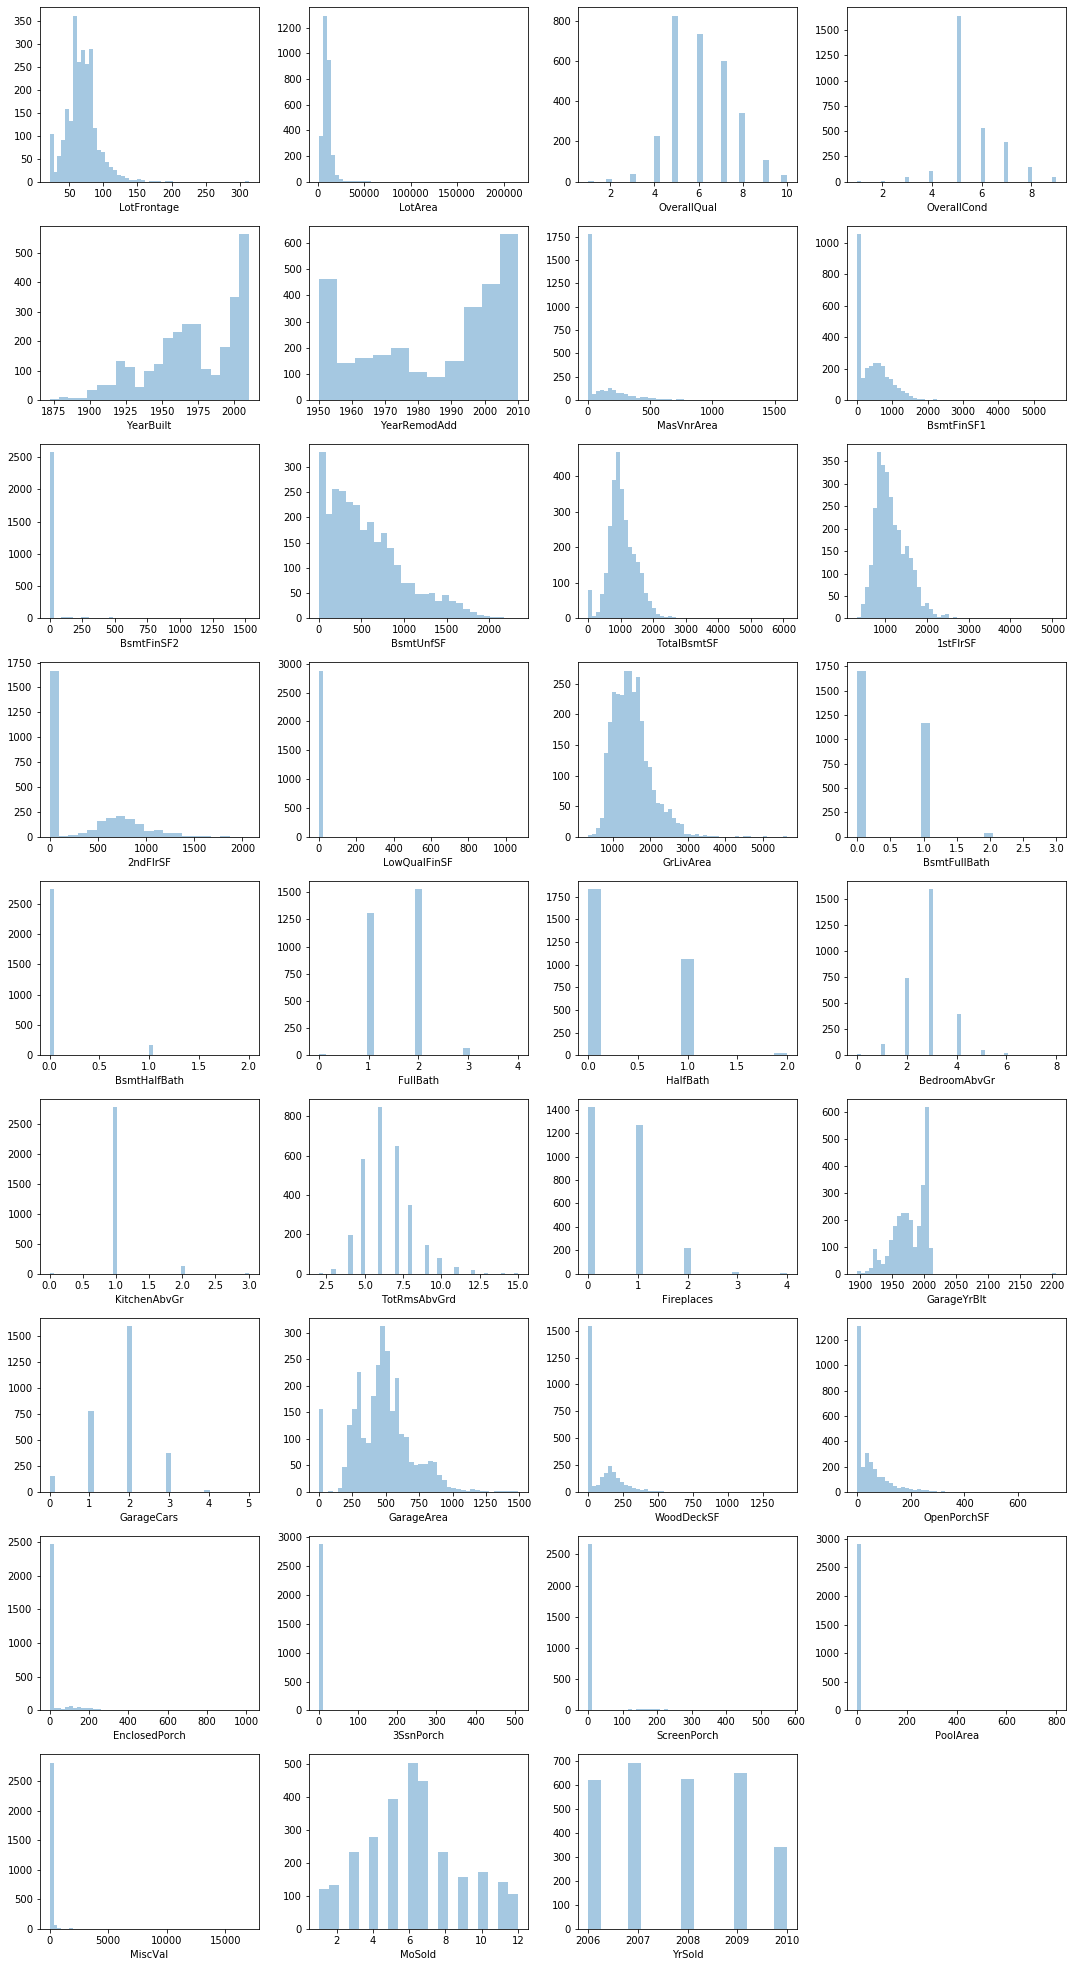

In [17]:
fig = plt.figure(figsize=(15,30))
for index, col in enumerate(num_features.columns):
    plt.subplot(10,4,index+1)
    sns.distplot(num_features[col], kde=False)
fig.tight_layout(pad=1.0)

### The above plots show that many of the features only have 1 value (that value being 0):
1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal

### The above features are highly skewed (being mostly 0's) and having only 1 value does not really add much to the analysis. These columns could be removed, I show how to do so below ALTHOUGH FOR THIS ANALYSIS I DID NOT ACTUALLY REMOVE THEM HERE

In [18]:
# This is how to remove all features that have mostly the same 
# value (i.e. overfitted). A threshold is set that will remove
# any feature that has > 96% of its data in one value

num_col = features.select_dtypes(exclude=['object']).columns
overfit_num = []
for i in num_col:
    counts = features[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(features) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
#features = features.drop(overfit_num, axis=1)

In [19]:
# Dropped Categorical Columns with >96% same value
#print(overfit_num)

### So ultimately, only 4 of the 7 features that I tagged above would be removed if used

---

### Bi-Variate Analysis (Numerical Features)
Below are correlation charts for the numerical features in order to better understand the target/feature realtionships as well as any potential multicorrelated features. 

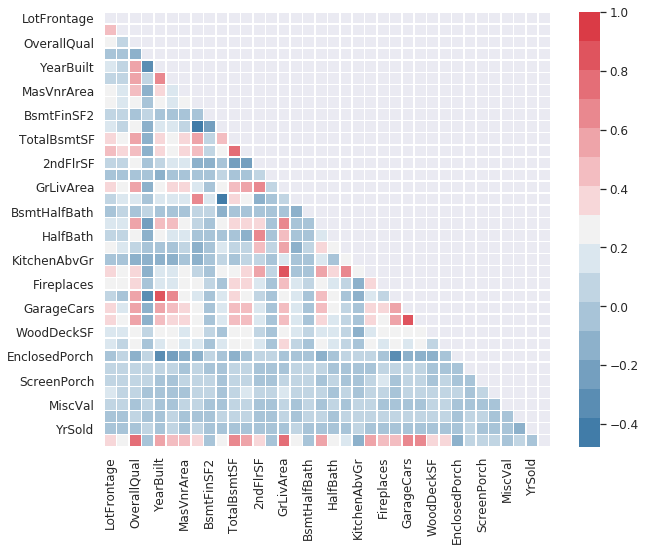

In [20]:
sns.set(font_scale=1.1)
features_corr = num_features.join(train['SalePrice']).corr()
mask = np.triu(features_corr.corr())

plt.figure(figsize=(10, 8))

sns.heatmap(features_corr,
            cmap=sns.diverging_palette(240, 10, n=15),
            mask = mask,
            linewidths=0.5)   

In [21]:
numeric_features = train.select_dtypes(exclude=['object'])
corr = numeric_features.corr()

# Top 10 features
corr[['SalePrice']].sort_values(['SalePrice'], ascending=False).head(11)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897




### Next I want to check for multicollinearity between features so that I can either combine or remove as necessary

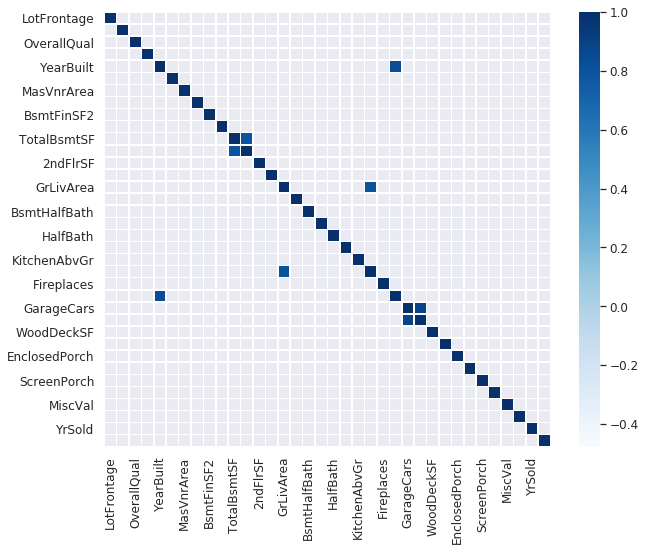

In [22]:
#DIAL THIS, SHOULD HAVE 1 MORE MULTICORRELATED SET, YEARBLT AND GARAGEYRBUILT
plt.figure(figsize=(10,8))
sns.heatmap(features_corr, mask = features_corr < 0.8, linewidth=0.5, cmap='Blues')

### Highly Correlated variables are:
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

Because these columns are going to get in the way of one another, either one from each pair should ideally be removed, the choice should come down to which one is more highly correlated with the target variable SalePrice

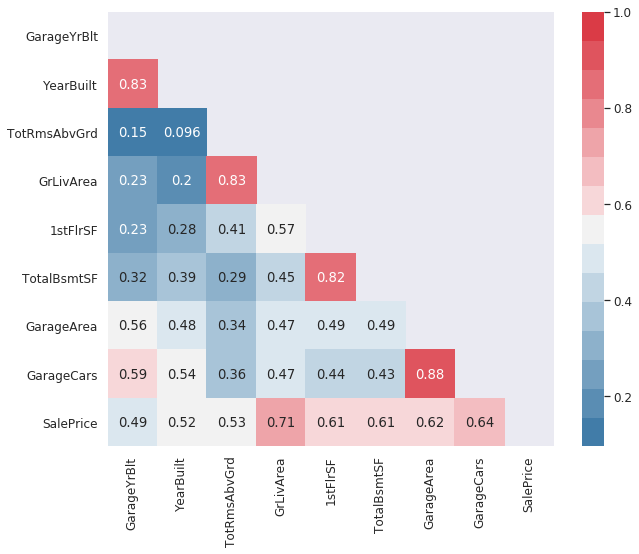

In [23]:
corr_vars = ['GarageYrBlt', 'YearBuilt', 'TotRmsAbvGrd',
             'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea',
             'GarageCars', 'SalePrice']

sns.set(font_scale=1.1)
train_corr = train[corr_vars].corr()
mask = np.triu(train_corr.corr())

plt.figure(figsize=(10, 8))

sns.heatmap(train_corr,
            cmap=sns.diverging_palette(240, 10, n=15),
            mask = mask,
            annot=True)  

### From the correlation matrix the columns I would remove are:
* GarageYrBlt
* TotRoomsAbvGrd
* 1stFlrSF
* GarageCars

### Removal of multi-correlated columns (NOT USED HERE)

In [24]:
# Remove multi-corrleted features

#features.drop(['GarageYrBlt','TotRmsAbvGrd',
#               '1stFlrSF','GarageCars'], axis=1, inplace=True)

### Removing non-linear columns that add nothing to the anlaysis

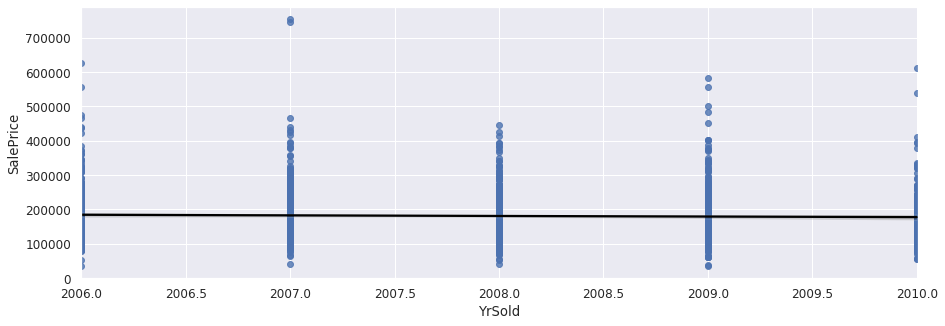

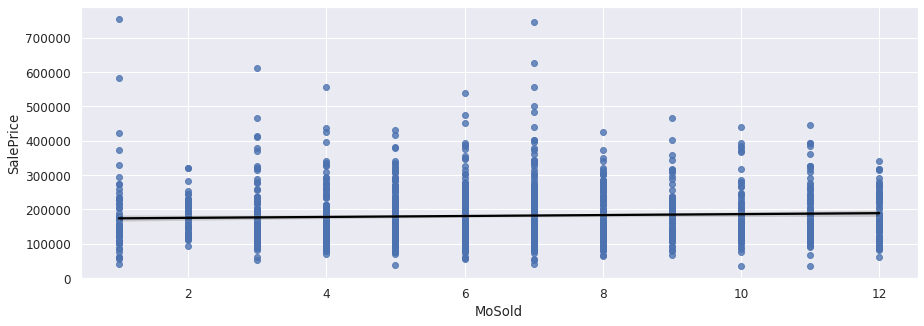

In [25]:
fig = plt.figure(figsize=(15,5))
sns.regplot(x=train['YrSold'], y='SalePrice', data=train, line_kws={'color':'black'})
plt.show()

fig = plt.figure(figsize=(15,5))
sns.regplot(x=train['MoSold'], y='SalePrice', data=train, line_kws={'color':'black'})
plt.show()

In [26]:
#features.drop(['YrSold','MoSold'], axis=1, inplace=True)

In [27]:
features.shape

(2919, 79)

---
## 3b. Categorical Feature Analysis
Categorical Features are handled differently than numerical and are best analyzed through either count plots or box plots

In [28]:
cat_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60.0
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20.0
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60.0
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,70.0
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal,NaN
2915,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,NaN
2916,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,NaN
2917,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal,NaN


### Univariate Analysis

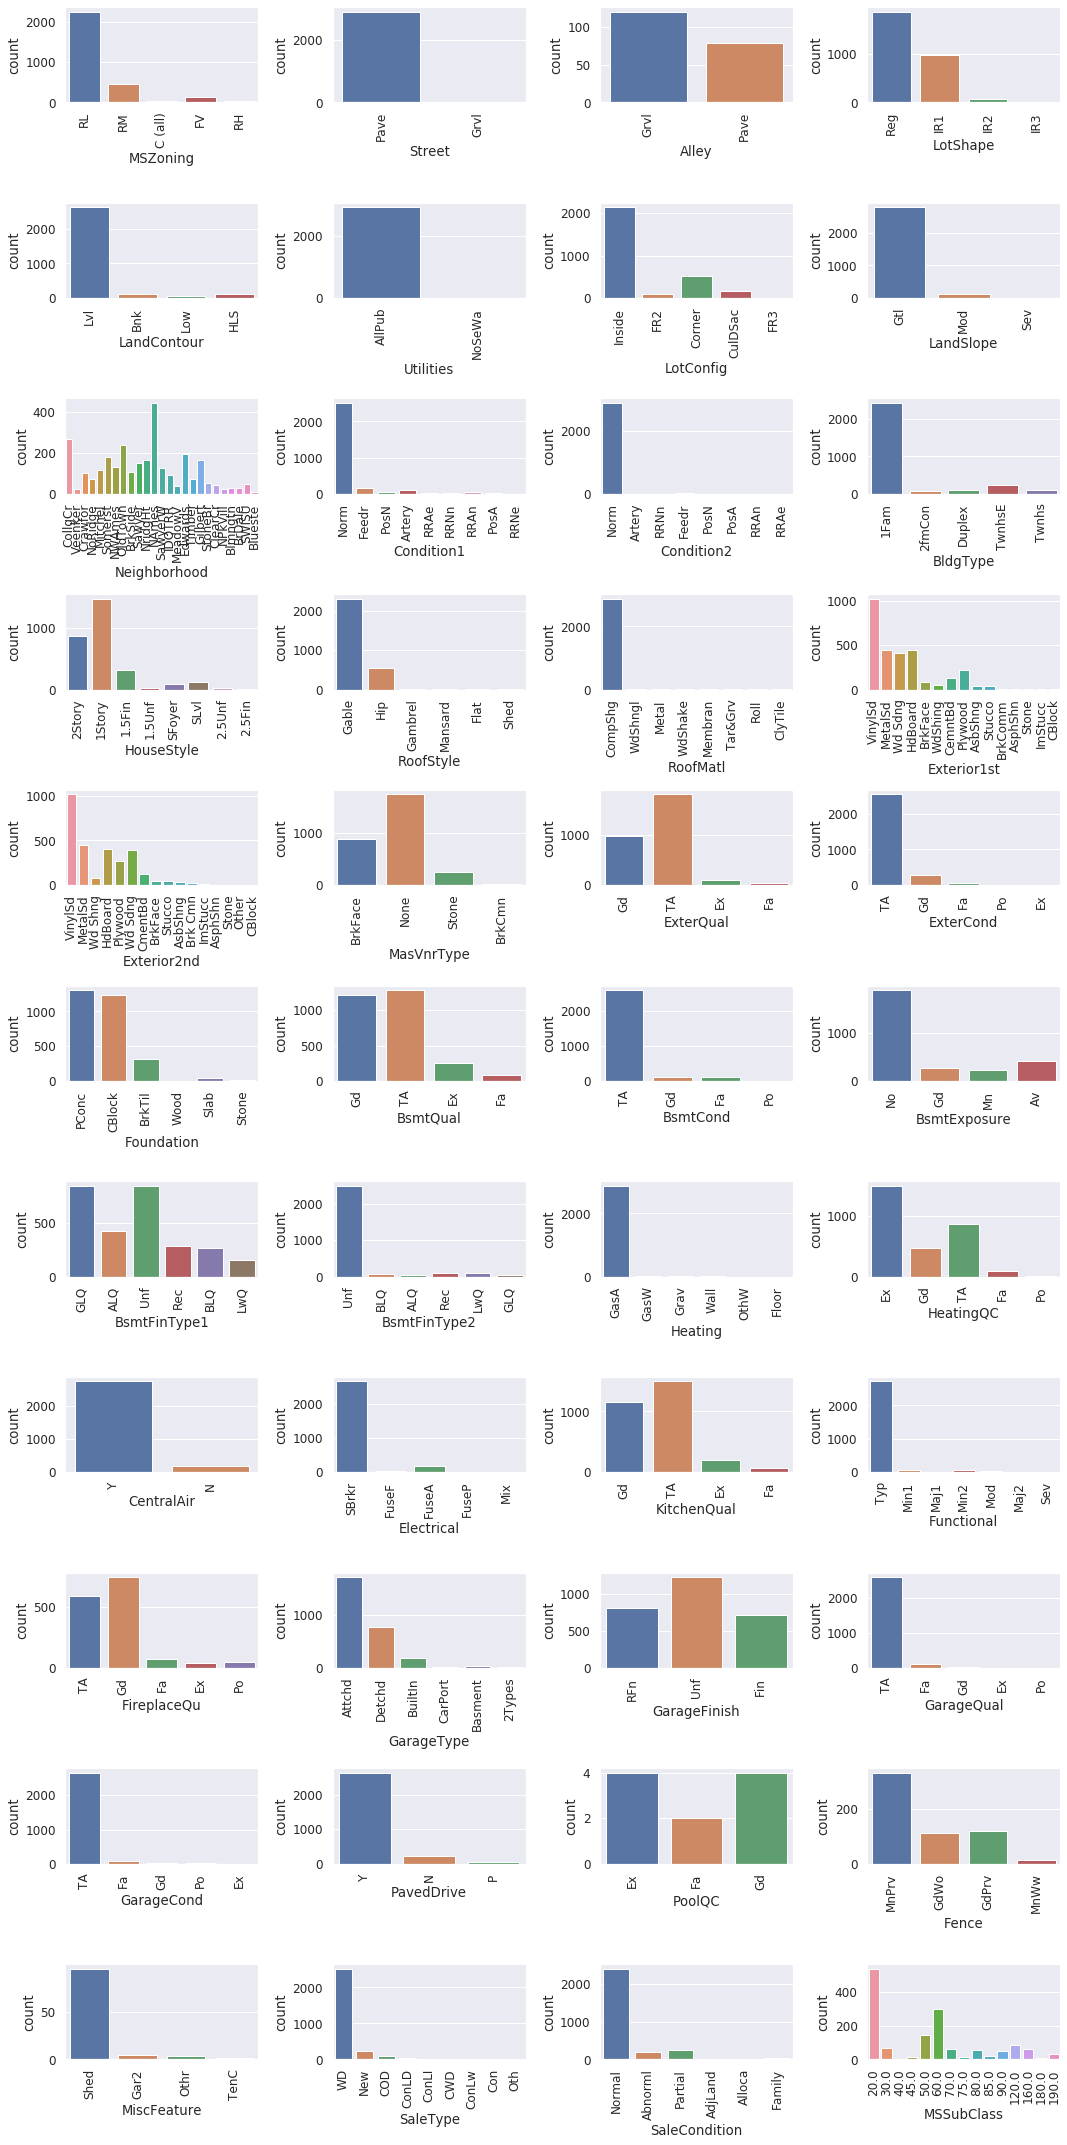

In [29]:
fig = plt.figure(figsize=(15,30))
for i, feat in enumerate(cat_features.columns):
    plt.subplot(11,4,i+1)
    sns.countplot(x=cat_features.iloc[:,i], data=cat_features)
    plt.xticks(rotation=90)  
fig.tight_layout(pad=1.0) # Padding allows x axis to be seen

### Note that all the categorical features with only (or almost only) 1 value have the same problem already found with the numerical features. Below I remove the ones that have 96% of its data in one value

In [30]:
# This is how to remove all features that have mostly the same 
# value (i.e. overfitted). A threshold is set that will remove
# any feature that has > 96% of its data in one value


cat_col = features.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = features[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(features) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
#features = features.drop(overfit_cat, axis=1)

In [31]:
# Dropped Categorical Columns 
#print(overfit_cat)

In [32]:
features.shape

(2919, 79)

### So 10 features can be dropped

---
## Outliers
In order to deal with outliers, I really want to focus in on the features that have the highest correlation with the Sale Price so I check boxplots for these below and remove outliers as necessary

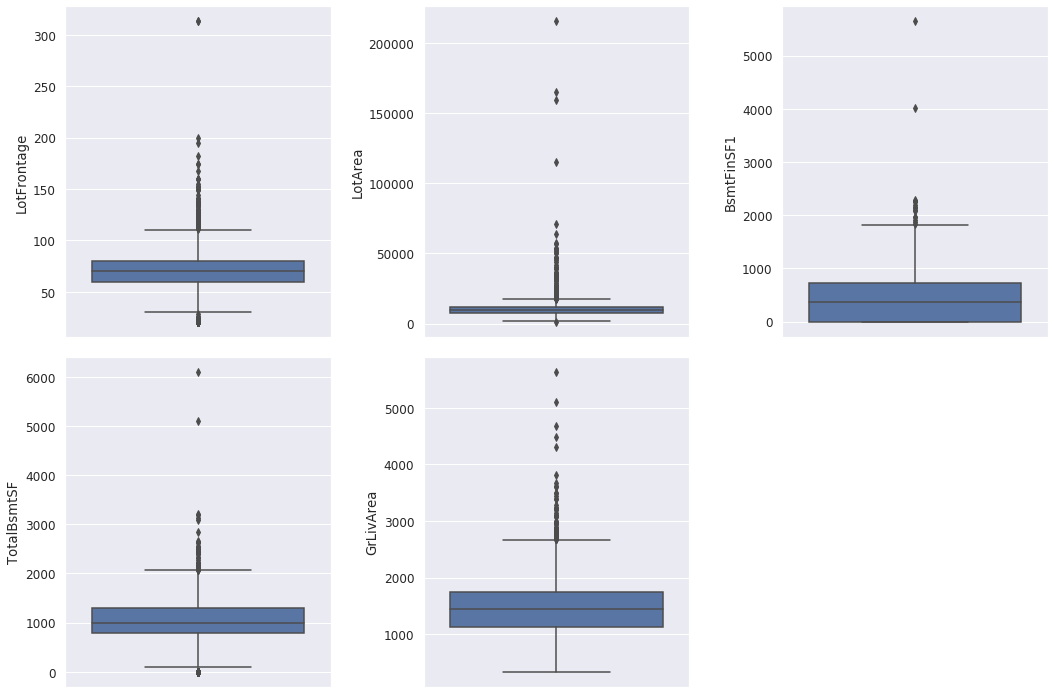

In [33]:
top_cor_feats = ['LotFrontage','LotArea',
                 'BsmtFinSF1','TotalBsmtSF',
                 'GrLivArea']

fig = plt.figure(figsize=(15,10))
for index,col in enumerate(top_cor_feats):
    plt.subplot(2,3,index+1)
    sns.boxplot(y=col, data=features)
fig.tight_layout(pad=1.5)

In [34]:
#features = features.join(train['SalePrice'])
#features = features.drop(features[(features['OverallQual'] < 5)
#                                  & (features['SalePrice'] > 200000)].index)
#features = features.drop(features[(features['GrLivArea'] > 4000)
#                                  & (features['SalePrice'] < 200000)].index)
#features = features.drop(features[(features['GarageArea'] > 1200)
#                                  & (features['SalePrice'] < 200000)].index)
#features = features.drop(features[(features['TotalBsmtSF'] > 3000)
#                                  & (features['SalePrice'] > 320000)].index)
#features = features.drop(features[(features['1stFlrSF'] < 3000)
#                                  & (features['SalePrice'] > 600000)].index)
#features = features.drop(features[(features['1stFlrSF'] > 3000)
#                                  & (features['SalePrice'] < 200000)].index)


#features.drop(columns='SalePrice', inplace=True)

In [35]:
features.shape

(2919, 79)

--- 

# 4. Feature Engineering
Feature Engineering is a technique in which new features are created that could potentially aid in target variable prediction. Note that only continuous numerical features can be combined. 

First I take another look at the numerical feature columns:

In [36]:
numeric_feats = features.dtypes[train.dtypes != "object"].index
features[numeric_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2919 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2919 non-null   float64
 8   BsmtFinSF1     2919 non-null   float64
 9   BsmtFinSF2     2919 non-null   float64
 10  BsmtUnfSF      2919 non-null   float64
 11  TotalBsmtSF    2919 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2919 non-null   float64
 17  BsmtHalfBath   2919 non-null   float64
 18  FullBath

### First I will deal with the 'MSSubClass' feature that is currenlty numerical but in reality should be categorical (nominal) as the numerical values have no order to them

In [37]:
# Convert mumerical featuers that are actually categorical
features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

---

## Conversion of Categorical Features to Numerical
Many of the categorical features have the same exact rating structures that can be turned into ordinal numerical values. For example these five metrics are used with two features:
* Ex - Excellent
* Gd - Good
* TA - Average
* Fa - Fair
* Po - Poor

Note that these metrics would work just as well like this:
* 5 - Excellent
* 4 - Good
* 3 - Average
* 2 - Fair
* 1 - Poor

The features that all can be converted like above are:
* ExterQual
* ExterCond

Below I create maps to help convert the similar features

In [38]:
nhood_map = {'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1,
             'BrkSide': 2, 'OldTown': 2, 'Edwards': 2,
             'Sawyer': 3, 'Blueste': 3, 'SWISU': 3,
             'NPkVill': 3, 'NAmes': 3, 'Mitchel': 4,
             'SawyerW': 5, 'NWAmes': 5, 'Gilbert': 5,
             'Blmngtn': 5, 'CollgCr': 5, 'ClearCr': 6,
             'Crawfor': 6, 'Veenker': 7, 'Somerst': 7,
             'Timber': 8, 'StoneBr': 9, 'NridgHt': 10,
             'NoRidge': 10}

map1 = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
map2 = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
map3 = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3,
            'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

# Convert neighborhood feature
features['Neighborhood'] = features['Neighborhood'].map(nhood_map).astype('int')

# Convert features with map1 metrics
features['ExterQual'] = features['ExterQual'].map(map1).astype('int')
features['ExterCond'] = features['ExterCond'].map(map1).astype('int')
features['HeatingQC'] = features['HeatingQC'].map(map1).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(map1).astype('int')

# Convert features with map2 metrics
features['BsmtQual'] = features['BsmtQual'].map(map2).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(map2).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(map2).astype('int')
features['GarageCond'] = features['GarageCond'].map(map2).astype('int')
features['GarageQual'] = features['GarageQual'].map(map2).astype('int')

# Convert features with map3 metrics
features['BsmtFinType1'] = features['BsmtFinType1'].map(map3).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(map3).astype('int')

---

## Creating New Features & Merging Similar Features

### Looking at the descriptors of the numerical variables in the contest supplied text file it appears that there are a few potential lyuseful new features that could be created from the old ones:

* TotalLot = LotFrontage + LotArea
* TotalSF = BsmtFinSF1 + BsmtFinSF2 + 1stFlrSF + 2ndFlrSF
* TotalBathrooms = FullBath + HalfBath + BsmtFullBath + BsmtHalfBath
* TotalPorchSF = OpenPorchSF + 3SsnPorch + ScreenPorch + Enclosed Porch + WoodDeckSF

**Note that YearBuilt and YearRemodelAdd are seemingly very similar, however they are not > 80% correlated and therefore combining could be a benefit, if there was no remodeling, then it will just be year built**
* TotalYrBlt = YearBuilt + YearRemodAdd


### Next features that contain both quality and condition measures are merged as these two metrics tend to go together (correlated)
* TotalExtQual = ExterQual + ExterCond
* TotalBsmtQual = BsmtQual + BsmtCond + BsmtFinType1 + BsmtFinType2
* TotalGrgQual = GarageQual + GarageCond
* TotalQual = OverallQual + TotalExtQual + TotalBsmQual + TotalGrgQual + KitchenQual + HeatingQC

In [39]:
# Turn this to code for original feature engineering

# Creating New Features From Old
features['TotalSF'] = (features['BsmtFinSF1'] + 
                       features['BsmtFinSF2'] +
                       features['1stFlrSF'] + 
                       features['2ndFlrSF'])

features['TotalBathrooms'] = (features['FullBath'] +
                              (0.5 * features['HalfBath']) +
                              features['BsmtFullBath'] +
                              (0.5 * features['BsmtHalfBath']))

features['TotalPorchSF'] = (features['OpenPorchSF'] + 
                            features['3SsnPorch'] +
                            features['EnclosedPorch'] +
                            features['ScreenPorch'] + 
                            features['WoodDeckSF'])


features['TotalYrBlt'] = (features['YearBuilt'] + 
                          features['YearRemodAdd'])


# Merging features with quality and condition metrics
features['TotalExtQual'] = (features['ExterQual'] +
                            features['ExterCond'])

features['TotalBsmQual'] = (features['BsmtQual'] +
                            features['BsmtCond'] +
                            features['BsmtFinType1'] +
                            features['BsmtFinType2'])

features['TotalGrgQual'] = (features['GarageQual'] +
                            features['GarageCond'])

features['TotalQual'] = (features['OverallQual'] +
                        features['TotalExtQual'] +
                        features['TotalBsmQual'] +
                        features['TotalGrgQual'] +
                        features['KitchenQual'] +
                        features['HeatingQC'])

### Dealing with skewness of numerical features

In [40]:
numeric_feats = features.dtypes[features.dtypes != "object"].index

# Finding skewness of the numerical features.
feature_skew = np.abs(features[numeric_feats].skew())

# Filtering skewed features.
high_skew = feature_skew[feature_skew > 0.3]

# Getting indexs of high skews
skew_index = high_skew.index
skew_index

Index(['LotFrontage', 'LotArea', 'Neighborhood', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'TotalYrBlt',
       'TotalBsmQual', 'TotalGrgQual', 'TotalQual'],
      dtype='object')

In [41]:
# Applying log transform to all highly skewed numerical features
features[skew_index] = np.log1p(features[skew_index])

# Applying BoxCox transformatio
#for i in skew_index:
#    features[i] = boxcox1p(features[i],
#                           scipy.stats.boxcox_normmax(features[i] + 1))

### Features to Drop

In [42]:
to_drop = [
    'Utilities',
    'PoolQC',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features

features.drop(columns=to_drop, inplace=True)

### Get Dummy Variables for Categorical Features

In [43]:
features = pd.get_dummies(data=features)
features.shape

(2919, 239)

---

# 5. Modeling
In this section I will transform or scale the data as needed and build each model 

In [44]:
X_train = features[: train.shape[0]]
X_test = features[train.shape[0] :]
y = train['SalePrice']

###  Targe Variable Distribution
The numerical features can all potentially be skewed. Because the target variable in a regression analysis has to be normally distributed, I will check SalePrice first. 

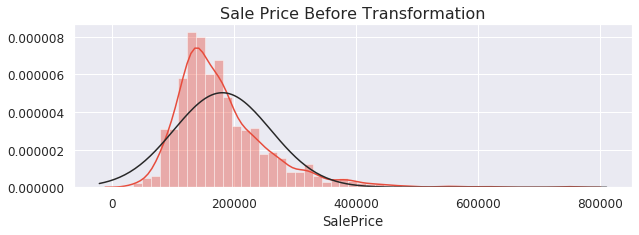

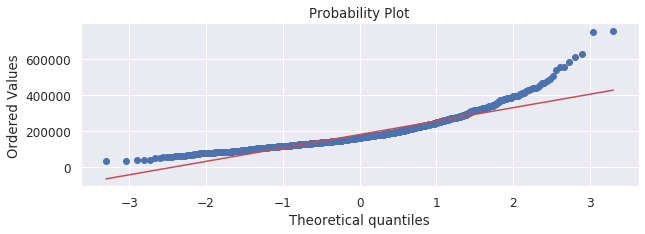

In [45]:
plt.figure(figsize=(10, 3))

# Histogram
sns.distplot(y,
             hist=True,
             kde=True,
             fit=scipy.stats.norm,
             color='#e74c3c')

plt.title('Sale Price Before Transformation', fontsize=16)
plt.show()


#Probabilty Plot
plt.figure(figsize=(10, 3))
res = scipy.stats.probplot(y,
                           plot=plt)
plt.show()

### Sale Price is not normally distributed. Because it has a positive skew log transformation could potentially normalize the data. 

In [46]:
y = np.log(y)

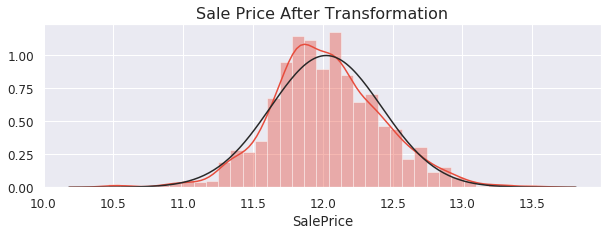

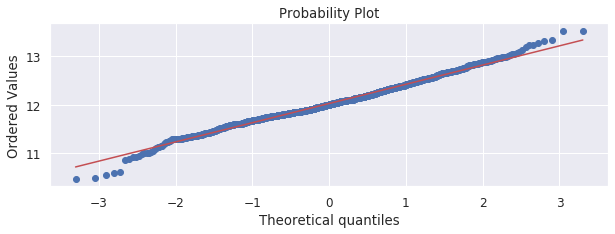

In [47]:
plt.figure(figsize=(10, 3))

# Histogram
sns.distplot(y,
             hist=True,
             kde=True,
             fit=scipy.stats.norm,
             color='#e74c3c')

plt.title('Sale Price After Transformation', fontsize=16)
plt.show()


#Probabilty Plot
plt.figure(figsize=(10, 3))
res = scipy.stats.probplot(y,
                           plot=plt)
plt.show()

### Now that SalePrice has been taken care of, I will examine the numerical features to determine if any need converting

---

## Building Models

In [117]:
# Cross-Validation Function
def rmse_cv(model):
    rmse = cross_val_score(model, 
                           X_train,
                           y, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 10)
    return(-rmse)

In [118]:
X_train.shape

(1460, 239)

In [119]:
X_train.isnull().sum()

LotFrontage              0
LotArea                  0
Neighborhood             0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 239, dtype: int64

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

In [121]:
# Setting kfold for future use.
kf = KFold(10, random_state=42, shuffle=True)

In [122]:
# Ridge Regression With Piping

ridge_alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# RidgeCV Model:

# Pipelines can be used to streamline the cross-validation process
# the first parameter is the scaling used, the second is the model,
# the third is the number of cross validation splits
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas=ridge_alphas, 
                      cv=kf))

rmse_cv(ridge).mean()

0.12554929859765426

In [123]:
# test for best alpha
ridge_test = RidgeCV(alphas= ridge_alphas).fit(X_train, y)
ridge_test.alpha_

10.0

### Next the LassoCV Regression model is used
For high-dimensional datasets with many collinear features, LassoCV is most often preferable.

Note that LassoCV stands for Lasso Cross Validation

In [124]:
# the third is the number of cross validation splits
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7,
                      alphas=[1, 0.1, 0.001, 0.0005],
                      cv=kf))

rmse_cv(lasso).mean()

0.12350751815252663

### Train/Split test to see if score comes cloe to median

In [106]:
print(X_train.shape)
print(y.shape)

(1460, 239)
(1460,)


In [107]:
# Ridge Regression Model
ridge3 = Ridge(alpha=15)

# Test/Train Split
X_train3, X_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.25,random_state=100)
ridge2.fit(X_train2, y_train)
y_pred_lin = ridge2.predict(X_test)


print('Ridge Regression Results:')
print('----------------------------------------')
# MAE
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred_lin)}')

# RMSE
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin))}')

Ridge Regression Results:
----------------------------------------
MAE: 0.09245132038216497
RMSE: 0.1329814915905893


In [108]:
actuals_conv = np.exp(y_test)
pred_conv = np.exp(y_pred_lin)

res_conv = actuals_conv - pred_conv

abs(res_conv).mean()

16488.524388028138

# TODO For some reason, dropping the outliers is messing up the calculations DIAL THIS, I'm pretty sure it has something to do with the fact that the the ouliers are removed from the combined features dataset and something may be off when they get re-split right before modeling. That or maybe the index just needs to be reset, I'm not sure, but burnt out on this notebook so willl come back later

# This was used in looking at outliers, but I haven't decided it i'm going to ultimately include it or not, the charting examples are good.

### Next I examine the top 10 features in order to determine if any outliers exist that should be removed

### Top Feature 1. 'OverallQual'

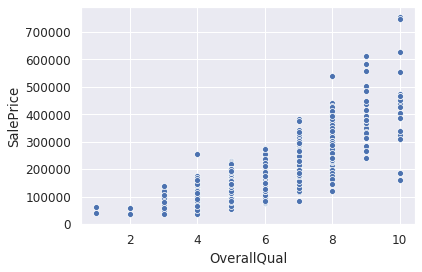

In [56]:
sns.scatterplot(data=train, x='OverallQual', y="SalePrice")
plt.show()

### There do appear to be a few potential outliers, however this is difficult to confirm in isolation as overall home quality does not necessarily reflect the sale price. For example a new small home may be cheap but could be of high quality and vice-versa  an old large home may be poorer quality but still sell high due to its size and/or location for example. Therefore I will not drop any sample based on overall quailty alone

### Top Feature 2: 'GrLivArea'

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64


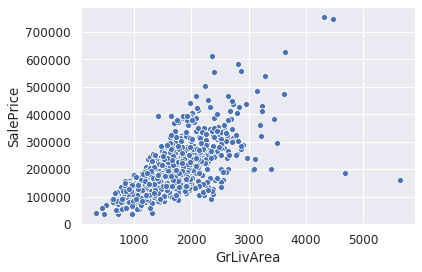

In [57]:
print(train['GrLivArea'].describe())

sns.scatterplot(data=train, x='GrLivArea', y="SalePrice")
plt.show()

### Outliers for this metric appear to occer when the area is approximately > 4500 or 3 standard deviations. However, lower sale prices with larger living areas could be explained by poorer overall house qualities, therefore I will weed out the outliers by removing any house that has:
* Living Area > 4500
* Sale Price < 200k
* Overall Quality > 5

In [58]:
# Drop Outliers as necessary from 'GrLivArea'
comb_feat = train.drop(train[(train['GrLivArea'] > 4500)
                             & (train['SalePrice'] < 200000)
                            & (train['OverallQual'] > 5)].index)

comb_feat.shape

(1458, 80)

### Top Feature 3: 'TotalBsmtSF'

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


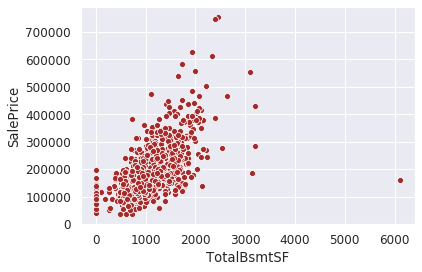

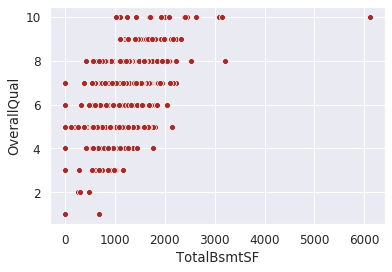

In [59]:
print(train['TotalBsmtSF'].describe())

sns.scatterplot(data=train, x='TotalBsmtSF', y="SalePrice", color='brown')
plt.show()

sns.scatterplot(data=train, x='TotalBsmtSF', y="OverallQual", color='brown')
plt.show()

### This features is definitely affected by at least one really large outlier which I will remove and recheck to see if the mean and median come closer together

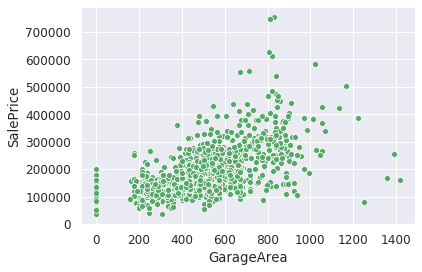

In [60]:
sns.scatterplot(data=train, x='GarageArea', y="SalePrice", color='g')
plt.show()
